### Final Report (Group #36)

In [1]:
# Load the packages and set the seed

library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(GGally)
library(gtable)
library(grid)
library(gridExtra)

options(repr.matrix.max.rows = 6)
set.seed(2022)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### INTRO:


In [2]:
url <- "https://raw.githubusercontent.com/sadia-kd/DSCI-Project/main/heart.csv"

heart_disease <- read_csv(url) %>%
    mutate(target = as_factor(target)) %>%
    unique()

heart_disease

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
52,1,0,128,255,0,1,161,1,0.0,2,1,3,0
59,1,3,160,273,0,0,125,0,0.0,2,0,2,0
54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


## _Performing the Analsyis_

# Final work start here

# split data

In [3]:
# spliting the data into training/testing sets, remove unwanted variables

selected_heart_disease = heart_disease %>%
    select(age,trestbps,thalach,chol,target)

heart_disease_split <- initial_split(selected_heart_disease, prop = 0.75, strata = target)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

# Evaluate accuracy for all 6 cases ( Combination of each two variables)

### variable selection method referred to as best subset selection (Beale, Kendall, and Mann 1967; Hocking and Leslie 1967). -  textbook chapter 6.8
Create a separate model for every possible subset of predictors, tune each one using cross-validation, and pick the subset of predictors that gives you the highest cross-validation accuracy.

For the best visualization, we only pick two variables out of four. Total is 6 cases which is C(4 ,2).

In [4]:
# age:1  trestbps:2 chol:3 thalach:4
predictors = c("age","trestbps","chol","thalach")

In [5]:
#Create plots to visualizae finding the best K value

get_k_accuracy_plot = function(predIndex1, predIndex2){
        #set seed
        set.seed(2022)
        
        #create formula
        formula = paste("target", "~", paste(predictors[predIndex1],sep = "+", predictors[predIndex2]))
        
        # tune spec for all cases
        knn_tune = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                      set_engine("kknn") %>%
                      set_mode("classification")
    
        # create function for creating recipe
        heart_recipe = recipe(as.formula(formula),data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())
    
        
        # Create the 5-fold cross-validation on the training set
        vfold = vfold_cv(heart_disease_train, v = 5, strata = target)

        # Create a data frame with a neighbors variable that contains the sequence of values of K to try. 
        # Containing values from 1 to 20
        k_vals = tibble(neighbors = seq(from = 1, to = 20, by = 5))
        
        # Get accuracy from different k
        knn_results = workflow() %>%
                       add_recipe(heart_recipe) %>%
                       add_model(knn_tune) %>%
                       tune_grid(resamples = vfold, grid = 10) %>%
                       collect_metrics()

        accuracies = knn_results %>%
                      filter(.metric == "accuracy")

        plot_title = paste("Neighbors vs accuracy estimate for k values: ", paste(predictors[predIndex1],sep = " and ", predictors[predIndex2]))    
    
        accuracy_versus_k = ggplot(accuracies, aes(x = neighbors, y = mean)) +
                             geom_point() +
                             geom_line() +
                             xlim(0,20) +
                             labs(x = "Neighbors", y = "Accuracy Estimate", title = plot_title) +
                             theme(text = element_text(size = 10)) 
        
    }

In [6]:
# case1: age vs trestbps
k_accuracy_plot_age_tre = get_k_accuracy_plot(1,2)

# case2: age vs chol
k_accuracy_plot_age_cho = get_k_accuracy_plot(1,3)

# case3: age vs thalach
k_accuracy_plot_age_tha = get_k_accuracy_plot(1,4)

# case4: trestbps vs chol
k_accuracy_plot_tre_cho = get_k_accuracy_plot(2,3)

# case5: trestbps vs thalach 
k_accuracy_plot_tre_tha = get_k_accuracy_plot(2,4)

# case6: chol vs thalach
k_accuracy_plot_cho_tha = get_k_accuracy_plot(3,4)

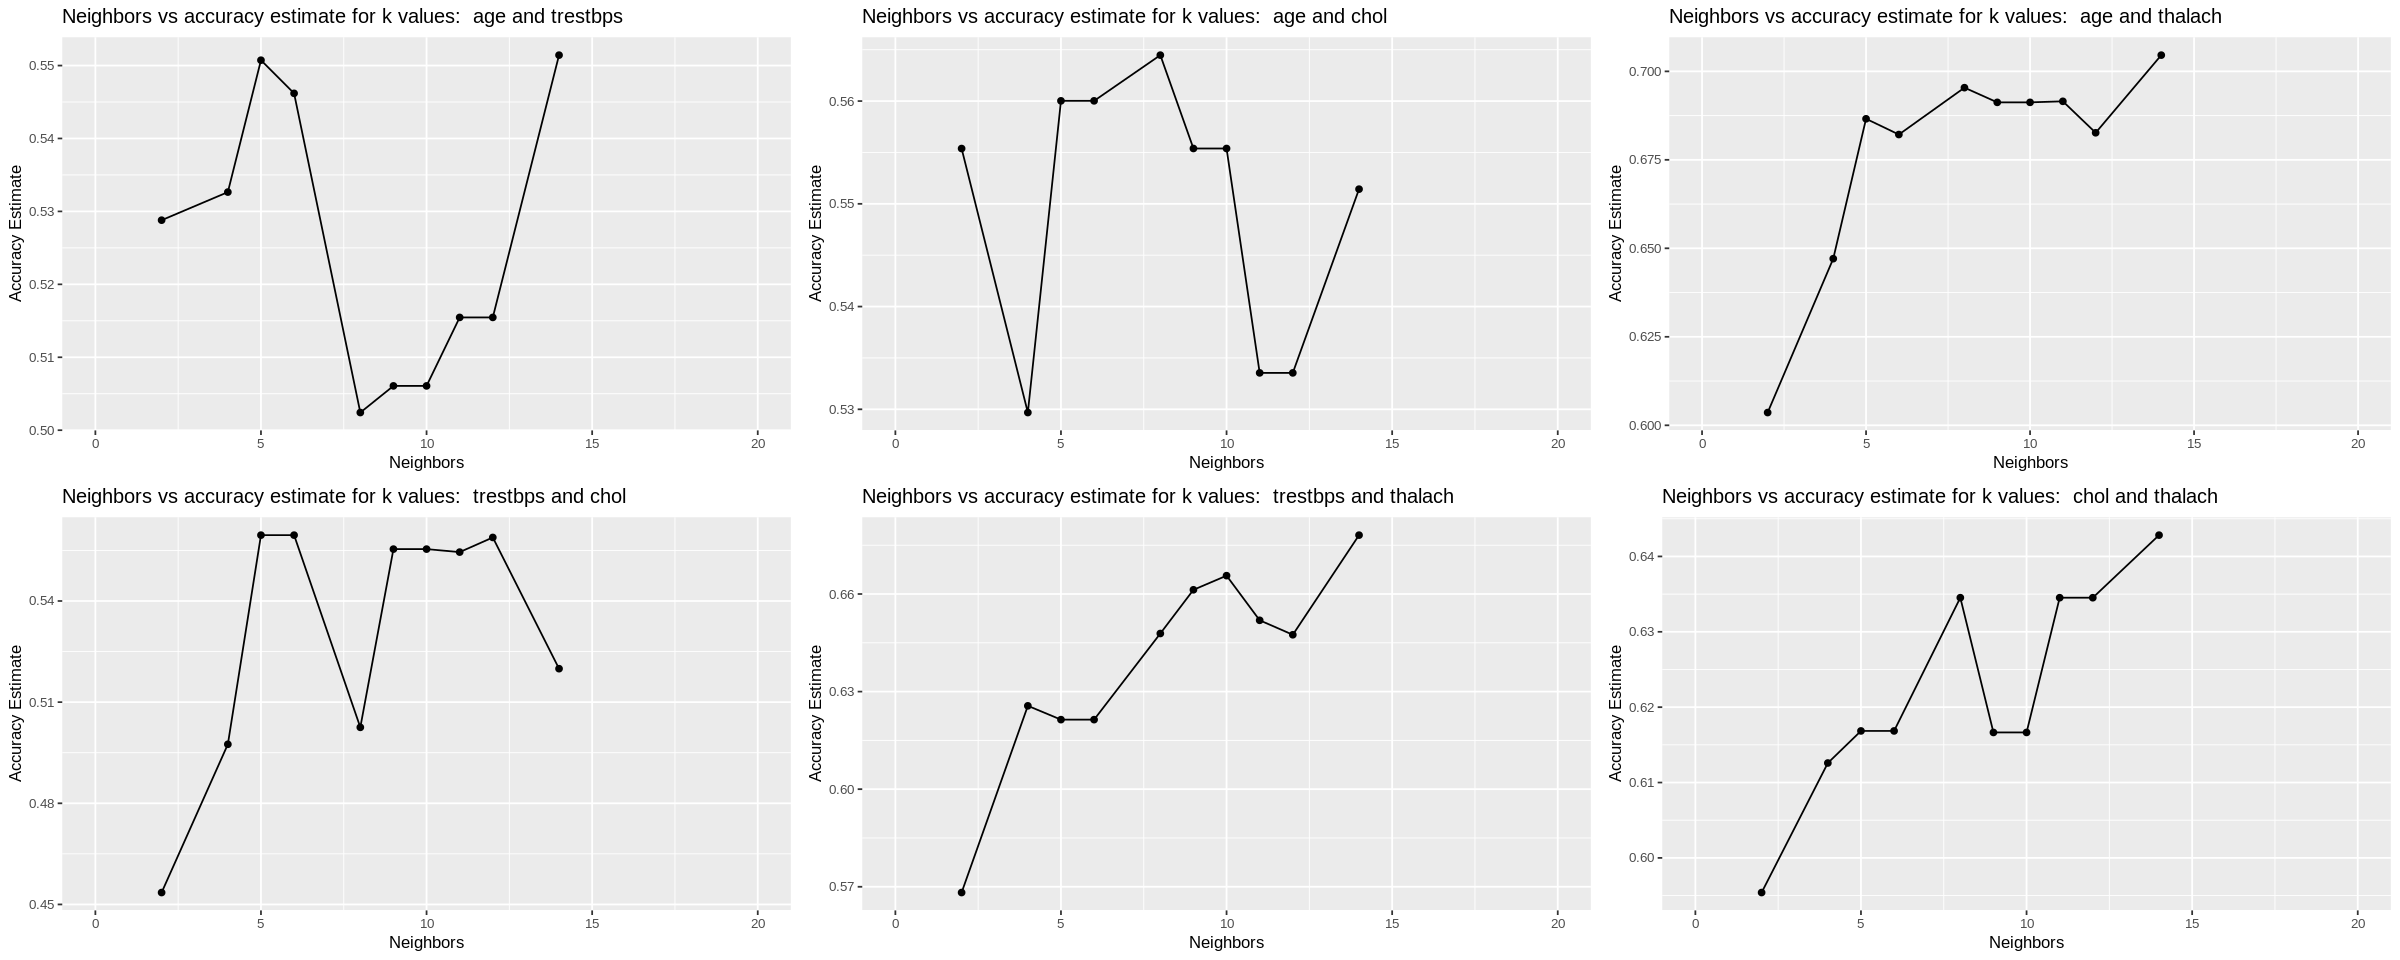

In [7]:
options(repr.plot.width = 20, repr.plot.height = 8)
grid.arrange(k_accuracy_plot_age_tre, k_accuracy_plot_age_cho,k_accuracy_plot_age_tha,k_accuracy_plot_tre_cho,k_accuracy_plot_tre_tha,k_accuracy_plot_cho_tha,
            nrow=2,ncol=3)

From above plots, we can get the best K for each cases:

- case1: age vs trestbps: k = 8

- case2: age vs chol: k = 14

- case3: age vs thalach: k = 10

- case4: trestbps vs chol: k = 14

- case5: trestbps vs thalach: k = 14

- case6: chol vs thalach: k = 8

# Classification for all cases

In [8]:
get_predictions = function(predIndex1, predIndex2, k){
        #set seed
        set.seed(2022)
        
        #create formula
        formula = paste("target", "~", paste(predictors[predIndex1],sep = "+", predictors[predIndex2]))
        
        # tune spec for all cases
        knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = k) %>%
                      set_engine("kknn") %>%
                      set_mode("classification")
    
        # create function for creating recipe
        heart_recipe = recipe(as.formula(formula),data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())
        
        # Get accuracy from different k
        heart_fit = workflow() %>%
                       add_recipe(heart_recipe) %>%
                       add_model(knn_spec) %>%
                       fit(data = heart_disease_train)
    
        # Do prediction and save result to the data frame
        predictions = predict(heart_fit,heart_disease_test) %>%
                        bind_cols(heart_disease_test)
        
    }

In [9]:
# case1: age vs trestbps, where k = 8
predictions_age_tre = get_predictions(1,2,8)

# case2: age vs chol, where k = 14
predictions_age_cho = get_predictions(1,3,14)

# case3: age vs thalach, where k = 10
predictions_age_tha = get_predictions(1,4,10)

# case4: trestbps vs chol, where k = 14
predictions_tre_cho = get_predictions(2,3,14)

# case5: trestbps vs thalach, where k = 14 
predictions_tre_tha = get_predictions(2,4,14)

# case6: chol vs thalach, where k = 8
predictions_cho_tha = get_predictions(3,4,8)

# Evaluate accuracy for all cases

In [10]:
# case1: age vs trestbps
prediction_accuracy_age_tre = predictions_age_tre %>%
        metrics(truth = target, estimate = .pred_class) %>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()
# case2: age vs chol
prediction_accuracy_age_cho = predictions_age_cho %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case3: age vs thalach
prediction_accuracy_age_tha = predictions_age_tha %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case4: trestbps vs chol
prediction_accuracy_tre_cho = predictions_tre_cho %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case5: trestbps vs thalach
prediction_accuracy_tre_tha = predictions_tre_tha %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull()  
# case6: chol vs thalach
prediction_accuracy_cho_tha = predictions_cho_tha %>%
        metrics(truth = target, estimate = .pred_class)%>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull() 

Combination = c("age vs trestbps", "age vs chol", "age vs thalach", "trestbps vs chol", "trestbps vs thalach","chol vs thalach")
Accuracy = c(prediction_accuracy_age_tre,prediction_accuracy_age_cho,prediction_accuracy_age_tha,
              prediction_accuracy_tre_cho,prediction_accuracy_tre_tha,prediction_accuracy_cho_tha)

df = data.frame(Combination,Accuracy) %>%
        arrange(desc(Accuracy))
df

Combination,Accuracy
<chr>,<dbl>
chol vs thalach,0.7466667
age vs thalach,0.7200000
trestbps vs thalach,0.7066667
age vs chol,0.6400000
age vs trestbps,0.5866667
trestbps vs chol,0.5866667


Therefore, we will use age and thalach, trestbps and thalach, chol and thalach for classification to get the best result.

# Visualizae accuracy via confusion matrix for three top best cases

In [11]:
# age vs thalach,	0.6800000
conf_mat_age_tha = predictions_age_tha %>% 
      conf_mat(truth = target, estimate = .pred_class)
cat("Confusion matrix for age vs thalach\n\n")
conf_mat_age_tha
cat("\n\n")

# trestbps vs thalach,	0.6533333
conf_mat_tre_tha = predictions_tre_tha %>% 
      conf_mat(truth = target, estimate = .pred_class)
cat("Confusion matrix for trestbps vs thalach\n\n")
conf_mat_tre_tha
cat("\n\n")

# chol vs thalach,	0.6133333
conf_mat_cho_tha = predictions_cho_tha %>% 
      conf_mat(truth = target, estimate = .pred_class)
cat("Confusion matrix for chol vs thalach\n\n")
conf_mat_cho_tha

Confusion matrix for age vs thalach



          Truth
Prediction  0  1
         0 22  9
         1 12 32



Confusion matrix for trestbps vs thalach



          Truth
Prediction  0  1
         0 20  8
         1 14 33



Confusion matrix for chol vs thalach



          Truth
Prediction  0  1
         0 23  8
         1 11 33

# Visualizae accuracy via colored prediction map

### age vs thalach, using k = 10

In [12]:
# create the grid of vals, and arrange in a data frame
a_grid <- seq(min(heart_disease_train$age), 
                max(heart_disease_train$age), 
                length.out = 100)
b_grid <- seq(min(heart_disease_train$thalach), 
                max(heart_disease_train$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(age = a_grid, 
                                thalach = b_grid))
# set spec 
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
                set_engine("kknn") %>%
                set_mode("classification")
    
# create function for creating recipe
heart_recipe = recipe(target~ age + thalach ,data = heart_disease_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
        
# Get accuracy from different k
heart_fit = workflow() %>%
                add_recipe(heart_recipe) %>%
                add_model(knn_spec) %>%
                fit(data = heart_disease_train)
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_disease_train, 
             mapping = aes(x = age, 
                           y = thalach, 
                           color = target), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = age, 
                           y = thalach, 
                           color = .pred_class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Heart Disease", 
       x = "age", 
       y = "thalach",
      title = "Colored prediction map using age and thalach, where k is 10") +
  scale_color_manual(labels = c("yes", "no"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

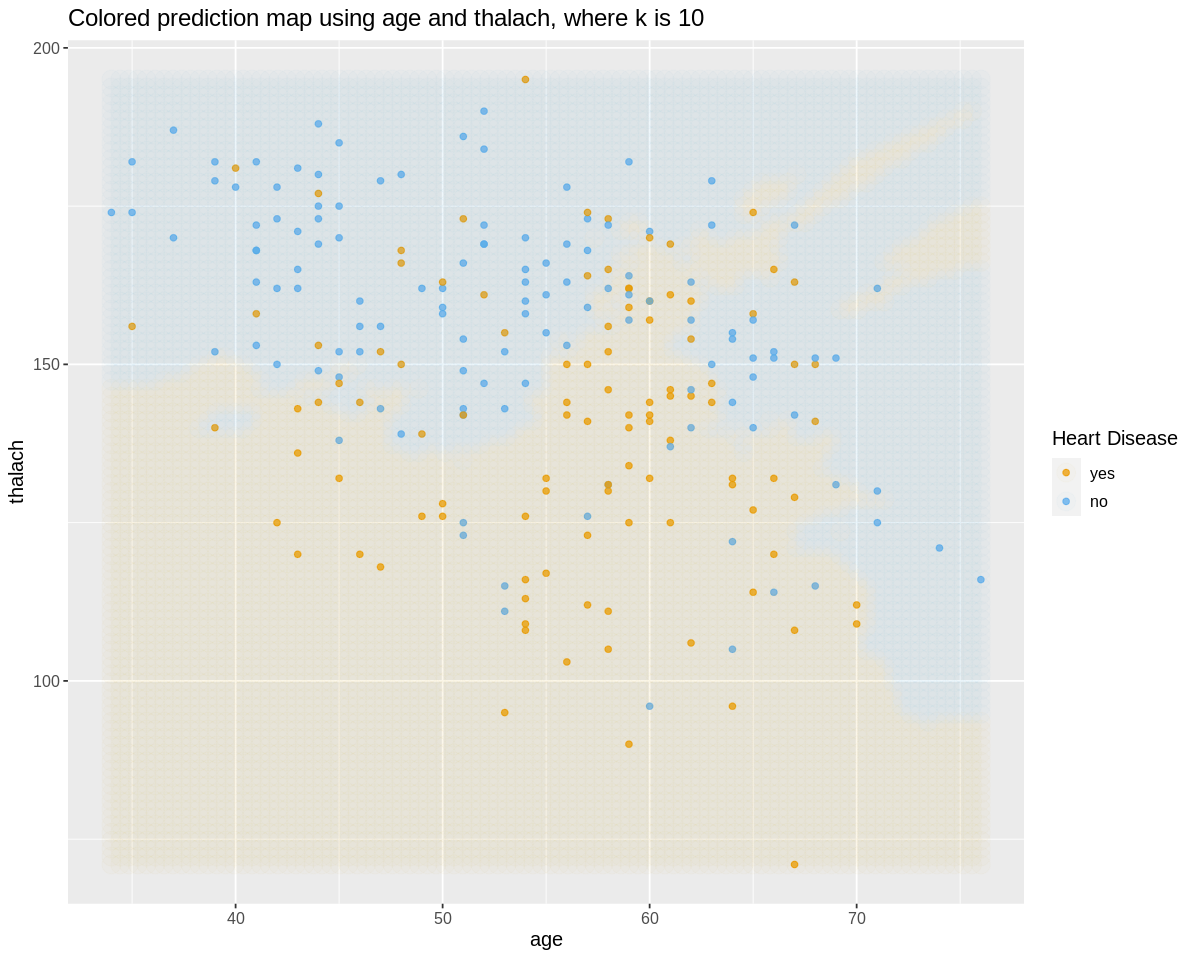

In [13]:
options(repr.plot.width = 10, repr.plot.height = 8)
wkflw_plot

### trestbps vs thalach, using k = 14

In [14]:
# create the grid of vals, and arrange in a data frame
a_grid <- seq(min(heart_disease_train$trestbps), 
                max(heart_disease_train$trestbps), 
                length.out = 100)
b_grid <- seq(min(heart_disease_train$thalach), 
                max(heart_disease_train$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(trestbps = a_grid, 
                                thalach = b_grid))
# set spec 
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
                set_engine("kknn") %>%
                set_mode("classification")
    
# create function for creating recipe
heart_recipe = recipe(target~ trestbps + thalach ,data = heart_disease_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
        
# Get accuracy from different k
heart_fit = workflow() %>%
                add_recipe(heart_recipe) %>%
                add_model(knn_spec) %>%
                fit(data = heart_disease_train)
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_disease_train, 
             mapping = aes(x = trestbps, 
                           y = thalach, 
                           color = target), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = trestbps, 
                           y = thalach, 
                           color = .pred_class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Heart Disease", 
       x = "trestbps", 
       y = "thalach",
      title = "Colored prediction map using trestbps and thalach, where k is 10") +
  scale_color_manual(labels = c("yes", "no"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

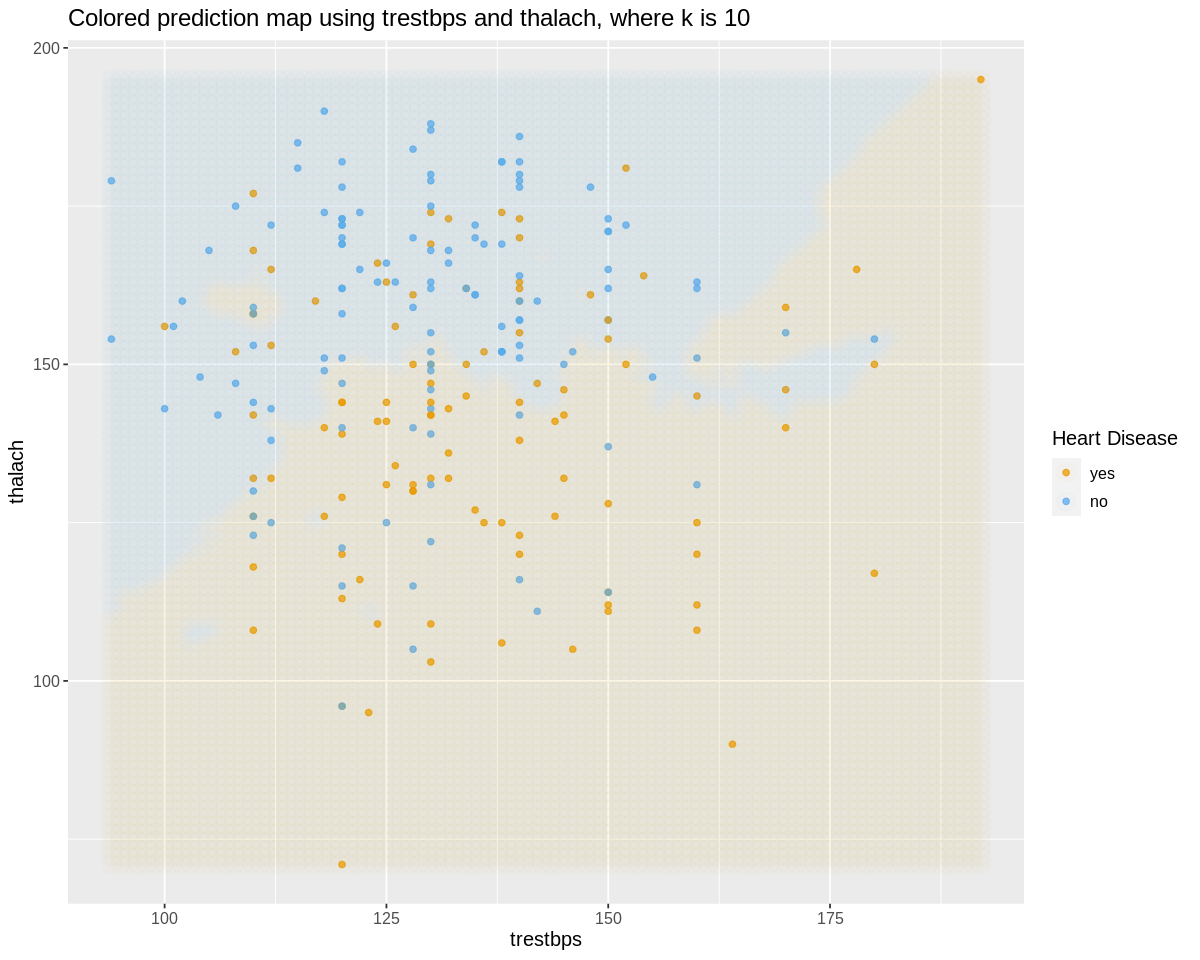

In [15]:
options(repr.plot.width = 10, repr.plot.height = 8)
wkflw_plot

### chol vs thalach, using k = 8

In [16]:
# create the grid of vals, and arrange in a data frame
a_grid <- seq(min(heart_disease_train$chol), 
                max(heart_disease_train$chol), 
                length.out = 100)
b_grid <- seq(min(heart_disease_train$thalach), 
                max(heart_disease_train$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(chol = a_grid, 
                                thalach = b_grid))
# set spec 
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 8) %>%
                set_engine("kknn") %>%
                set_mode("classification")
    
# create function for creating recipe
heart_recipe = recipe(target~ chol + thalach ,data = heart_disease_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
        
# Get accuracy from different k
heart_fit = workflow() %>%
                add_recipe(heart_recipe) %>%
                add_model(knn_spec) %>%
                fit(data = heart_disease_train)
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_disease_train, 
             mapping = aes(x = chol, 
                           y = thalach, 
                           color = target), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = chol, 
                           y = thalach, 
                           color = .pred_class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Heart Disease", 
       x = "chol", 
       y = "thalach",
      title = "Colored prediction map using chol and thalach, where k is 8") +
  scale_color_manual(labels = c("yes", "no"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

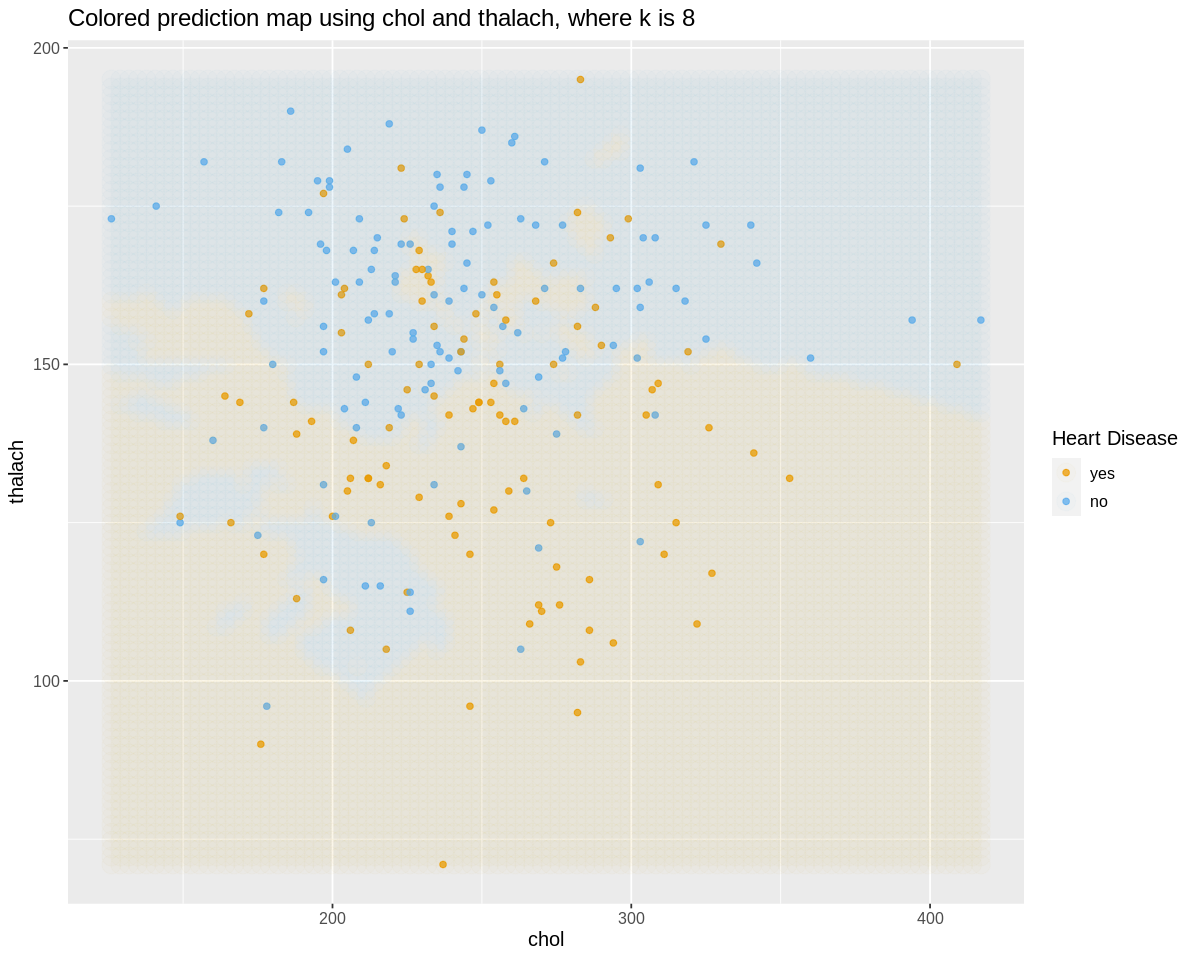

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8)
wkflw_plot